# Preprocessing of Datasets

After installation a dataset needs some steps of preprocessing before being fed to down-stream pipelines.

In this tutorial shows how to do
- label ramification...

Preprocessing can be applied on 3 consecutive levels
- File-level
- Data-level
- Model-level

We use the dataset CWRU as example but the same principle can be adapted to other datasets.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import librosa
import librosa.display

import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path

from IPython.display import Audio

In [2]:
import dpmhm

from dpmhm.datasets import transformer, preprocessing, feature, utils

First we load the dataset `CWRU` into memory. The original dataset doesn't specify the split, and all data are contained in the field `train`.

In [3]:
dataset_name = 'CWRU'

ds_all, ds_info = tfds.load(
    dataset_name, 
    # data_dir='/home/han/Database/tensorflow_datasets/',
    # split=['train[:75%]', 'train[75%:]'],    
    with_info=True,
    download=False,
    # batch_size=-1,  # load the whole dataset into a single batch
#     download_and_prepare_kwargs
)

print(ds_all.keys())  # show the split of the raw dataset

ds0 = ds_all['train']

dict_keys(['train'])


2022-12-21 15:18:31.953819: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-21 15:18:31.953848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Pluto): /proc/driver/nvidia/version does not exist
2022-12-21 15:18:31.954896: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The method `.element_spec()` shows the specification of elements. All dataset of `dpmhm` contains the fields `{'label', 'signal', 'sampling_rate', 'metadata'}`. The meta-information about the record is stored in  'metadata' which is specific to every dataset.

In [4]:
ds0.element_spec

{'label': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'metadata': {'FaultComponent': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultLocation': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultSize': TensorSpec(shape=(), dtype=tf.float32, name=None),
  'FileName': TensorSpec(shape=(), dtype=tf.string, name=None),
  'LoadForce': TensorSpec(shape=(), dtype=tf.uint32, name=None),
  'NominalRPM': TensorSpec(shape=(), dtype=tf.uint32, name=None),
  'RPM': TensorSpec(shape=(), dtype=tf.uint32, name=None)},
 'sampling_rate': TensorSpec(shape=(), dtype=tf.uint32, name=None),
 'signal': {'BA': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'DE': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'FE': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}}

We note for CWRU that (not a general rule for other datasets of `dpmhm`)
- `metadata` has a subfiled `FaultLocation`, but this is a redundant copy of the field `label`.
- The normal data can be equivalently identified by any of the following clauses: `label==0`, `FaultComponent==None`, `FaultSize==0`.


Let's plot and play a sample from the dataset:

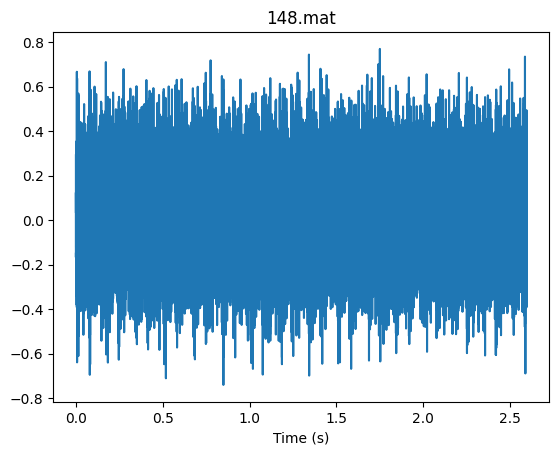

In [23]:
eles = list(ds0.take(10).as_numpy_iterator())

fn = eles[0]['metadata']['FileName'].decode()
sr = eles[0]['sampling_rate']
x = eles[0]['signal']['FE']

plt.figure()
plt.plot(np.arange(len(x))/sr, x)
plt.xlabel('Time (s)')
plt.title(fn)

Audio(x, rate=sr)

### File-level preprocessing

#### Filter on the channel
CWRU contains 3 channels ['DE', 'FE', 'BA'], however some channels may be absent in certain files (e.g. the file `148.mat` contains only channels 'DE' and 'FE', not 'BA'). A first preprocessing step hence consists in selecting only the files in which some desired channels are simultaneously present. 

#### Ramification of labels
The original label takes value in ['None', 'DriveEnd', 'FanEnd'] (or the numeric value [0,1,2]), meaning that
- there is no fault
- the fault locates at the drive-end
- the fault locates at the fan-end

We want to incorporate more information and make new labels at a finer level. For this, we take into account the subfield `FaultComponent` and `FaultSize` of the field `metadata`:
- `FaultComponent`: taking value in {'InnerRace', 'Ball', 'OuterRace3', 'OuterRace6', 'OuterRace12', 'None'}
- `FaultSize`: taking value in {0.007, 0.014, 0.021, 0.028, 0}

Together with the original label, the new label becomes a triplet `(label, FaultComponent, FaultSize)`. For example, the triplet `(1, 'InnerRace', 0.007)` means the fault is located at drive-end, on the inner-race component, of size 0.007.

#### Resampling & sliding window view
The record in CWRU has variant duration (~10 or 2.5 seconds) and sampling rate (at 12000 or 48000 Hz) which may complicate the subsequent analysis. So we resample all signals at the fixed rate of 16000 Hz and trim them into windows of 1 second with hop size 0.5 second.

#### Selection of domain 
We define *domain* as the operating load force of a record. Note that in CWRU the field `LoadForce` (taking value in [0,1,2,3]) is one-to-one mapped to the nominal RPM `NominalRPM` (taking value in [797, 1772, 1750, 1730]). We want to test if an algorithm of detection trained on some domains can work on the others (called *domain-shift*).


In [82]:
# Filter on the channels
channels = ['DE', 'FE', 'BA']  
# channels = ['DE']  

# Label ramification
keys = ['FaultComponent', 'FaultSize']
# keys = []

compactor = transformer.DatasetCompactor(ds0, channels=channels, keys=keys, 
                                         resampling_rate=16000, window_size=16000, hop_size=8000)

In [89]:
ds1 = compactor.dataset

eles = list(ds1.take(10).as_numpy_iterator())

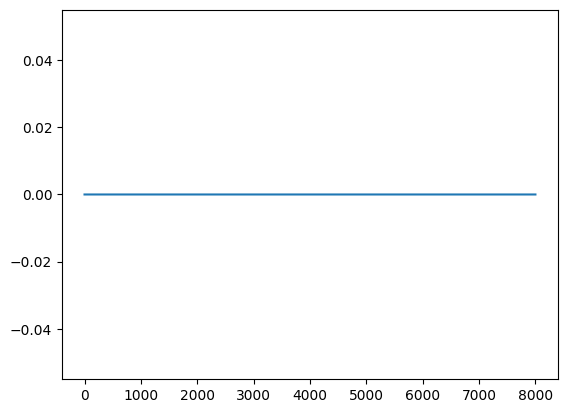

In [97]:
plt.plot(eles[0]['signal'][0][8000:]-eles[1]['signal'][0][:8000])

In [36]:
dataset = ds1

# tensor_shape = list(dataset.take(1))[0]['signal'].shape

# Output signature for the windowed view on the feature dataset.
_output_signature = {
    'label': dataset.element_spec['label'],
    'metadata': dataset.element_spec['metadata'],
#     'signal': tf.TensorSpec(shape=tf.TensorShape((1,16000)), dtype=tf.float32),
    'signal': tf.TensorSpec(None, dtype=tf.float32),
    'sampling_rate': dataset.element_spec['sampling_rate'],
    # 'feature': tuple([tf.TensorSpec(shape=tf.TensorShape(tensor_shape), dtype=_DTYPE)]*fold),
}

In [37]:
from tensorflow.data import Dataset

ds2 = Dataset.from_generator(_generator(ds1, 'signal'), output_signature=_output_signature)

In [42]:
from numpy.lib.stride_tricks import sliding_window_view


In [45]:
import skimage

In [68]:
from tensorflow.data import Dataset

In [69]:
isinstance(ds0, Dataset)

True

In [ ]:
skimage.filters.gaussian

In [43]:
sliding_window_view(np.zeros(10),3)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [40]:
eles[0]['signal'].ndim

2

In [38]:
list(ds2.take(1).as_numpy_iterator())

Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
(4, 1, 16000) (1, 4, 1, 16000)
(1, 16000)
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...


[{'label': b'1f9da202',
  'metadata': {'FaultComponent': b'OuterRace3',
   'FaultLocation': b'DriveEnd',
   'FaultSize': 0.007,
   'FileName': b'148.mat',
   'LoadForce': 0,
   'NominalRPM': 1797,
   'RPM': 1797},
  'signal': array([[ 0.3082189 ,  0.27160054, -0.09134221, ...,  0.34947565,
           0.36552915,  0.05573419]], dtype=float32),
  'sampling_rate': 16000}]

In [57]:
ds = ds1.map(lambda X: (X['label'], X['metadata'], tf.py_function(
        func=lambda S: dpmhm.utils.slislider(S.numpy(), window_shape, downsample),
        inp=[X['feature']],
        Tout=_DTYPE)),
        num_parallel_calls=tf.data.AUTOTUNE)


(1, 2)

In [6]:
_extractor = lambda x, sr: feature.spectrogram(x, sr, time_window=0.025, hop_step=0.0125, to_db=True, normalize=False)

outdir = Path('/home/han/tmp/') / dataset_name / 'spectrogram'
# extractor = lambda x, sr: feature.melspectrogram(x, sr, time_window=0.025, hop_step=0.0125, n_mels=128, normalize=True)
# outdir = Path('/home/han/tmp/cwru/mel')

window_shape = (64, 64)
downsample = (64, 64)

# window_shape = 64
# downsample = 64

#### For full domain-adaptation

Transfer learning is applied (training & validation) on the full domain LoadForce=[0,1,2,3]

In [5]:
compactor = preprocessing.DatasetCompactor(ds0, keys=keys, channels=channels)

extractor = preprocessing.FeatureExtractor(compactor.dataset, _extractor)

slider = preprocessing.WindowSlider(extractor.dataset, window_shape=window_shape, downsample=downsample)

fp = tempfile.mkdtemp()

slider.serialize(fp)

# dss = slider.dataset.shuffle(buffer_size=5000, seed=1234)
# dss = slider.dataset.take(5)
paired_pos = preprocessing.PairedView(slider.dataset, keys=['FileName'], positive=True)
paired_neg = preprocessing.PairedView(slider.dataset, keys=['FileName'], positive=False)

# paired_pos.dataset
# paired_neg.dataset

In [60]:
paired_neg.dataset.element_spec

({'label': TensorSpec(shape=<unknown>, dtype=tf.string, name=None),
  'metadata': {'FaultSize': TensorSpec(shape=(), dtype=tf.float32, name=None),
   'FaultComponent': TensorSpec(shape=(), dtype=tf.string, name=None),
   'FileName': TensorSpec(shape=(), dtype=tf.string, name=None),
   'NominalRPM': TensorSpec(shape=(), dtype=tf.uint32, name=None),
   'LoadForce': TensorSpec(shape=(), dtype=tf.uint32, name=None),
   'RPM': TensorSpec(shape=(), dtype=tf.uint32, name=None),
   'FaultLocation': TensorSpec(shape=(), dtype=tf.string, name=None)},
  'feature': TensorSpec(shape=(3, 64, 64), dtype=tf.float32, name=None)},
 {'label': TensorSpec(shape=<unknown>, dtype=tf.string, name=None),
  'metadata': {'FaultSize': TensorSpec(shape=(), dtype=tf.float32, name=None),
   'FaultComponent': TensorSpec(shape=(), dtype=tf.string, name=None),
   'FileName': TensorSpec(shape=(), dtype=tf.string, name=None),
   'NominalRPM': TensorSpec(shape=(), dtype=tf.uint32, name=None),
   'LoadForce': TensorSpec(sh

In [59]:
for x in paired_pos.dataset.take(10).as_numpy_iterator():
    print(x[0]['label'], x[1]['label'])
    print(x[0]['metadata'], x[1]['metadata'])

b'd39d8931' b'd39d8931'
{'FaultSize': 0.014, 'FaultComponent': b'InnerRace', 'FileName': b'276.mat', 'NominalRPM': 1750, 'LoadForce': 2, 'RPM': 1755, 'FaultLocation': b'FanEnd'} {'FaultSize': 0.014, 'FaultComponent': b'InnerRace', 'FileName': b'276.mat', 'NominalRPM': 1750, 'LoadForce': 2, 'RPM': 1755, 'FaultLocation': b'FanEnd'}
b'd39d8931' b'd39d8931'
{'FaultSize': 0.014, 'FaultComponent': b'InnerRace', 'FileName': b'276.mat', 'NominalRPM': 1750, 'LoadForce': 2, 'RPM': 1755, 'FaultLocation': b'FanEnd'} {'FaultSize': 0.014, 'FaultComponent': b'InnerRace', 'FileName': b'276.mat', 'NominalRPM': 1750, 'LoadForce': 2, 'RPM': 1755, 'FaultLocation': b'FanEnd'}
b'd39d8931' b'd39d8931'
{'FaultSize': 0.014, 'FaultComponent': b'InnerRace', 'FileName': b'276.mat', 'NominalRPM': 1750, 'LoadForce': 2, 'RPM': 1755, 'FaultLocation': b'FanEnd'} {'FaultSize': 0.014, 'FaultComponent': b'InnerRace', 'FileName': b'276.mat', 'NominalRPM': 1750, 'LoadForce': 2, 'RPM': 1755, 'FaultLocation': b'FanEnd'}
b'd3

In [20]:
dc_kwargs = {
    'keys': keys,
    'channels': channels,
#     'filters': {'LoadForce': [0,1,2]}
    # 'resampling_rate': 16000
}

ft_kwargs = {
    'window_shape': window_shape,
    'downsample': downsample
}

preprocessor = preprocessing.Preprocessor(ds0, extractor, dc_kwargs=dc_kwargs, ft_kwargs=ft_kwargs)

# %time preprocessor.dataset_windows.save(str(outdir/'full_domain'))

labels = list(preprocessor.label_dict.keys())

# preprocessor.dataset_windows  # reloaded dataset with better performance

In [22]:
ele = list(preprocessor.dataset_feature.take(1))[0]

X = ele['feature']

plt.imshow(X.numpy().squeeze(), aspect='auto')

In [4]:
dw = tf.data.Dataset.load(str(outdir/'full_domain'))

splits = {'train':0.1, 'val':0.7, 'test':0.2}
# splits = {'train':0.8, 'val':0.2}
# splits = {'train':1.0, 'val':0.}

sp_kwargs = {
    'shuffle_size': None,
    'reshuffle_each_iteration': False,
}

# These two ways of split give similar results:
# %time dw_split = utils.split_dataset(dw, splits, labels=None, **sp_kwargs)  # uniformly random split
%time dw_split = utils.split_dataset(dw, splits, labels=labels, **sp_kwargs)  # Few-shot style split, much slower

for k, ds in dw_split.items():
    print(k, utils.get_dataset_size(ds))  # len(ds) might not work here, use utils.get_dataset_size(ds)

NameError: name 'labels' is not defined

NameError: name 'dw_split' is not defined

In [7]:
# Optionally, save & load again the split dataset for better performance

# for k,v in dw_split.items():
#     v.save(str(outdir/'full_domain'/str(splits)/k))    

# dw_split = {}
# for p in (outdir/'full_domain'/str(splits)).iterdir():
#     dw_split[p.name] = tf.data.Dataset.load(str(p))      
    
# # Loading from files makes the size information available 
# for k, ds in dw_split.items():
#     print(k, len(ds))        